In [ ]:
import pandas as pd
from datetime import datetime
import seaborn as sns

import re
import numpy as np
from collections import Counter

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, recall_score, precision_score

from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE

from keras import Input, Model, optimizers, callbacks
from keras.layers import Bidirectional, LSTM, Dense, Concatenate
from keras import backend as K

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
warn_nasdaq_cleaned_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/warn_jaccard_0.5_cleaned.csv")
warn_nasdaq_cleaned_df = warn_nasdaq_cleaned_df.drop(["id1", "joinKey1", "joinKey2", "jaccard"], axis=1)
warn_nasdaq_cleaned_df = warn_nasdaq_cleaned_df.drop_duplicates(subset=["OG-Company-Warn", "Symbol"])
warn_nasdaq_cleaned_df = warn_nasdaq_cleaned_df.set_index("OG-Company-Warn")
print(warn_nasdaq_cleaned_df['Symbol'].unique().shape)
warn_nasdaq_cleaned_df.head()

(579,)


,Symbol,OG-Company-Nasdaq
OG-Company-Warn,,
Credit Suisse Asset Management LLC (CSAM),CIK,Credit Suisse Asset Management Income Fund Inc...
"G-III Apparel Group, Ltd. (3 NYC sites)",GIII,G-III Apparel Group LTD. Common Stock
Royal Caribbean Cruises Ltd.,RCL,D/B/A Royal Caribbean Cruises Ltd. Common Stock
M&T Bank (Mid-Hudson),MTB,M&T Bank Corporation Common Stock
"Delta Air Lines, Inc-Pilot Base",DAL,Delta Air Lines Inc. Common Stock


In [ ]:
warn_layoffs_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/warn_1.csv", index_col='id')
warn_layoffs_df["Date"] = warn_layoffs_df["WARN Received Date"].fillna(warn_layoffs_df["Effective Date"])
warn_layoffs_df["Number of Workers"] = warn_layoffs_df["Number of Workers"].str.strip()
warn_layoffs_df["Number of Workers"] = warn_layoffs_df["Number of Workers"].str.replace(r",","", regex=False)
warn_layoffs_df = warn_layoffs_df[~warn_layoffs_df["Number of Workers"].isna()]
warn_layoffs_df = warn_layoffs_df[warn_layoffs_df["Number of Workers"] != '']
warn_layoffs_df = warn_layoffs_df.astype({'Date': 'datetime64[ns]', 'Number of Workers': 'int64'})
warn_layoffs_df = warn_layoffs_df[[
    "State", "City", "Company", "Number of Workers", "Date"
]]
warn_layoffs_df = warn_layoffs_df.drop_duplicates()
# print(warn_layoffs_df.shape)
# Limit analysis to 2010 and after
warn_layoffs_df = warn_layoffs_df[warn_layoffs_df["Date"] > pd.to_datetime("2010-01-01")]
print(warn_layoffs_df.shape)
warn_layoffs_df.head()

<ipython-input-60-e70f3cdd9e90>:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  warn_layoffs_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/warn_1.csv", index_col='id')


(38686, 5)


,State,City,Company,Number of Workers,Date
id,,,,,
0,Alabama,Daleville,"Primus Solutions, LLC",132,2021-07-28
1,Alabama,Jasper,Corsicana Mattress Company,42,2021-07-26
2,Alabama,Birmingham,Portfolio Recovery Associates LLC,133,2021-07-20
3,Alabama,Gadsden,Crothall Healthcare Environmental Services,58,2021-07-07
4,Alabama,Decatur,National Packaging Co. Inc.,62,2021-06-30


In [ ]:
warn_layoffs_df.describe()

,Number of Workers
count,38686.000000
mean,111.524867
std,280.778736
min,0.000000
25%,23.000000
50%,63.000000
75%,116.000000
max,23695.000000


In [ ]:
layoffs_symbol_df = warn_layoffs_df.join(other=warn_nasdaq_cleaned_df, how="inner", on="Company")
layoffs_symbol_df = layoffs_symbol_df.reset_index(drop=True)
layoffs_symbol_df = layoffs_symbol_df.drop(["Company"], axis=1)
layoffs_symbol_df = layoffs_symbol_df.rename({"OG-Company-Nasdaq": "Company"}, axis=1)
layoffs_symbol_df = layoffs_symbol_df[~layoffs_symbol_df["Number of Workers"].isna()]
layoffs_symbol_df = layoffs_symbol_df[["Date", "Symbol", "Company", "Number of Workers"]]
layoffs_symbol_df = layoffs_symbol_df.groupby(by=["Date", "Symbol", "Company"], as_index=False).sum()
layoffs_symbol_df = layoffs_symbol_df.sort_values(by="Date", ascending=True).reset_index(drop=True)
print(f"Layoff events count = {layoffs_symbol_df.shape[0]}")
print(f"Unique layoff company count = {layoffs_symbol_df['Symbol'].unique().shape[0]}")
layoffs_symbol_df

Layoff events count = 2110
Unique layoff company count = 527


,Date,Symbol,Company,Number of Workers
0,2010-01-05,M,Macy's Inc Common Stock,72
1,2010-01-06,MHK,Mohawk Industries Inc. Common Stock,190
2,2010-01-07,AXP,American Express Company Common Stock,55
3,2010-01-14,BAC,Bank of America Corporation Common Stock,50
4,2010-01-14,IP,International Paper Company Common Stock,2
...,...,...,...,...
2105,2023-01-10,JBL,Jabil Inc. Common Stock,205
2106,2023-01-11,PSX,Phillips 66 Common Stock,45
2107,2023-01-12,ANF,Abercrombie & Fitch Company Common Stock,11
2108,2023-01-18,INTC,Intel Corporation Common Stock,544


In [ ]:
layoffs_symbol_df = layoffs_symbol_df.sort_values(['Symbol', 'Date']).reset_index(drop=True)
layoffs_symbol_df

,Date,Symbol,Company,Number of Workers
0,2015-11-09,AA,Alcoa Corporation Common Stock,415
1,2012-05-01,AAL,American Airlines Group Inc. Common Stock,550
2,2012-06-28,AAL,American Airlines Group Inc. Common Stock,1
3,2012-07-01,AAL,American Airlines Group Inc. Common Stock,2
4,2012-07-23,AAL,American Airlines Group Inc. Common Stock,187
...,...,...,...,...
2105,2019-03-27,XRAY,DENTSPLY SIRONA Inc. Common Stock,49
2106,2020-04-02,XRAY,DENTSPLY SIRONA Inc. Common Stock,461
2107,2020-04-09,YELP,Yelp Inc. Common Stock,375
2108,2010-02-22,ZUMZ,Zumiez Inc. Common Stock,172


In [ ]:
fed_rates = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/economic_indicatorFEDERAL_FUNDS_RATE.csv')
fed_rates = fed_rates.astype({'timestamp': 'datetime64', 'value': 'float64'})
fed_rates = fed_rates.rename({'value': 'fed_rate'}, axis=1)
fed_rates['m-y'] = fed_rates.apply(lambda r: f"{r['timestamp'].month}-{r['timestamp'].year}", axis=1)
fed_rates

,timestamp,fed_rate,m-y
0,2023-02-01,4.57,2-2023
1,2023-01-01,4.33,1-2023
2,2022-12-01,4.10,12-2022
3,2022-11-01,3.78,11-2022
4,2022-10-01,3.08,10-2022
...,...,...,...
819,1954-11-01,0.83,11-1954
820,1954-10-01,0.85,10-1954
821,1954-09-01,1.07,9-1954
822,1954-08-01,1.22,8-1954


In [ ]:
industry_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/company_industry_data.csv')

def map_industry(raw_industry: str):
    s = set(re.split(r"\W", raw_industry.lower()))
    sets = {
        'Energy': set(['oil', 'coal', 'solar']),
        'Financial': set(['banks', 'financial', 'asset', 'credit', 'finance', 'insurance', 'capital']),
        'Industrial': set(['steel', 'copper', 'aluminum', 'metal', 'chemicals', 'metals', 'paper', 'industrial']),
        'IT': set(['software', 'information']),
        'Medical': set(['medical', 'healthcare', 'pharmaceutical', 'drug']),
        'Real Estate': set(['reit', 'residential', 'estate']),
        'Auto': set(['auto', 'vehicles']),
        'Utilities': set(['utilities', 'waste']),
        'FB': set(['foods', 'food', 'beverages']),
        'Electronics': set(['semiconductor', 'semiconductors', 'electronics', 'electronic', 'computer']),
        'Services': set(['services']),
        'Apparel': set(['apparel', 'textile']),
        'Retail': set(['stores', 'retail']),
        'Entertainment': set(['resorts', 'leisure']),
        'Equipment': set(['equipment', 'machinery', 'tools']),
        'Agriculture': set(['farm', 'agricultural']),
        'Logistic': set(['logistics', 'trucking']),
        'Construction': set(['building', 'construction']),
    }
    for k, v in sets.items():
        if len(v.intersection(s)) > 0:
            return k
    return raw_industry
industry_df['industry_compact'] = industry_df['industry'].map(map_industry)
industry_count = industry_df['industry_compact'].value_counts()
industry_df

,stock_symbol,company_name,industry,industry_compact
0,CIK,"Credit Suisse Asset Management Income Fund, Inc.",Asset Management,Financial
1,GIII,"G-III Apparel Group, Ltd.",Apparel Manufacturing,Apparel
2,RCL,Royal Caribbean Cruises Ltd.,Travel Services,Services
3,MTB,M&T Bank Corporation,Banks—Regional,Financial
4,DAL,"Delta Air Lines, Inc.",Airlines,Airlines
...,...,...,...,...
574,AOS,A. O. Smith Corporation,Specialty Industrial Machinery,Industrial
575,ROG,Rogers Corporation,Electronic Components,Electronics
576,CVX,Chevron Corporation,Oil & Gas Integrated,Energy
577,BLBD,Blue Bird Corporation,Auto Manufacturers,Auto


<Axes: xlabel='Number of Workers', ylabel='Count'>

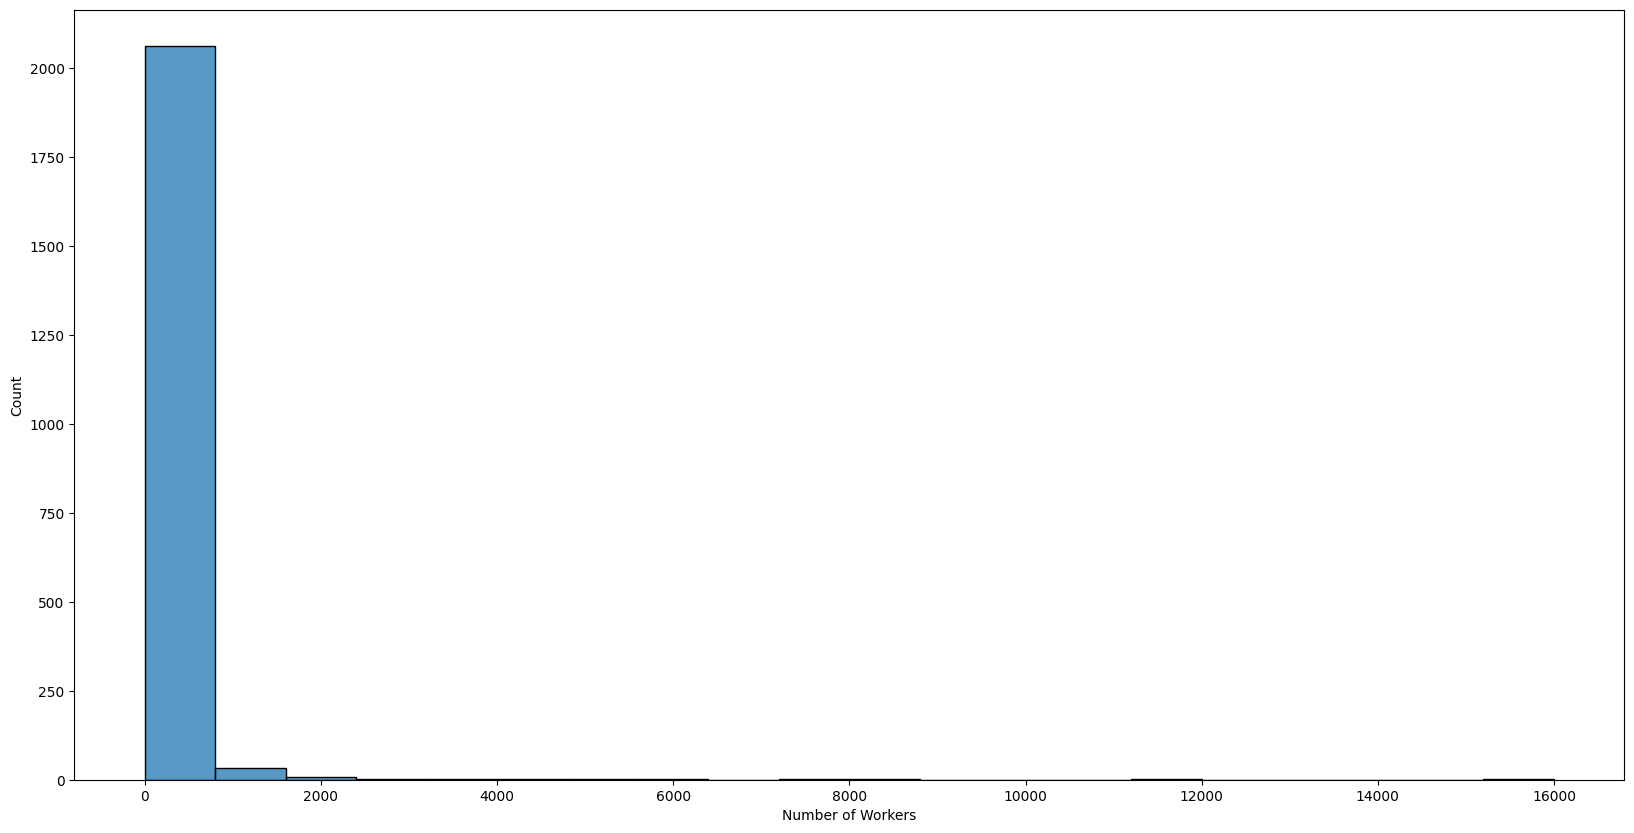

In [ ]:
sns.histplot(data=layoffs_symbol_df, x='Number of Workers',bins=20)
# print(layoffs_symbol_df[layoffs_symbol_df['Number of Workers']>10].shape)
# print(layoffs_symbol_df[layoffs_symbol_df['Number of Workers']<=10].shape)

In [ ]:
fmp_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/combined_company_financials.csv")
fmp_df = fmp_df.rename({'date': 'statement_date'}, axis=1).astype({'statement_date': 'datetime64'})
fmp_df.describe()

,revenue,costOfRevenue,grossProfit,grossProfitRatio,ResearchAndDevelopmentExpenses,GeneralAndAdministrativeExpenses,SellingAndMarketingExpenses,otherExpenses,operatingExpenses,costAndExpenses,...,dividendsPaid,otherFinancingActivites,netCashUsedProvidedByFinancingActivities,effectOfForexChangesOnCash,netChangeInCash,cashAtEndOfPeriod,cashAtBeginningOfPeriod,operatingCashFlow,capitalExpenditure,freeCashFlow
count,6.131300e+04,6.131300e+04,6.131300e+04,6.131300e+04,6.131300e+04,6.131300e+04,6.131300e+04,6.131300e+04,6.131300e+04,6.131300e+04,...,5.675800e+04,5.675800e+04,5.675800e+04,5.675800e+04,5.675800e+04,5.675800e+04,5.675800e+04,5.675800e+04,5.675800e+04,5.675800e+04
mean,1.309785e+10,8.183430e+09,2.218045e+09,3.664038e+01,5.254635e+07,2.608388e+08,4.272516e+07,1.708569e+08,1.434717e+09,9.648595e+09,...,-2.094845e+08,1.712739e+09,2.192101e+07,-6.410066e+05,9.465723e+07,4.802606e+09,4.729998e+09,1.174967e+09,-8.951995e+08,3.181662e+08
std,2.361802e+11,1.821370e+11,4.042851e+10,5.411060e+03,3.627247e+08,1.049077e+09,4.738800e+08,1.515520e+09,2.294967e+10,2.048154e+11,...,5.794797e+09,8.732306e+11,8.724520e+11,2.265001e+09,1.734694e+10,1.005524e+11,9.740883e+10,2.672865e+10,2.422036e+10,1.293039e+10
min,-2.375800e+10,-2.795500e+10,-7.461369e+10,-2.610000e+02,-3.241000e+08,-4.589222e+10,-1.200515e+10,-2.820900e+10,-2.749800e+10,-1.003500e+10,...,-3.933520e+11,-1.469494e+14,-1.469494e+14,-1.763999e+11,-1.287123e+12,-2.765700e+10,-1.900000e+08,-6.466660e+11,-1.139087e+12,-8.829357e+11
25%,1.360000e+08,2.451086e+07,1.316500e+07,1.258424e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.554200e+07,6.507400e+07,...,-3.360000e+07,-2.386000e+06,-9.472500e+07,-7.000000e+03,-2.765625e+07,1.112025e+07,1.521925e+07,3.700000e+06,-1.030000e+08,-6.700000e+06
50%,6.028200e+08,2.404450e+08,1.157640e+08,2.841772e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.679800e+07,4.023150e+08,...,-2.055000e+06,2.300000e+06,-6.094500e+06,0.000000e+00,0.000000e+00,1.212045e+08,1.258095e+08,4.650000e+07,-2.245150e+07,1.633100e+07
75%,2.182561e+09,1.072800e+09,5.321000e+08,4.545153e-01,0.000000e+00,7.300000e+07,0.000000e+00,1.843100e+07,3.760000e+08,1.665528e+09,...,0.000000e+00,1.136428e+08,7.800000e+06,0.000000e+00,3.527500e+07,6.760645e+08,6.789115e+08,2.689008e+08,-4.200000e+06,1.449000e+08
max,8.150033e+12,6.755385e+12,1.656703e+12,1.155420e+06,2.081400e+10,1.933800e+10,4.593812e+10,2.014468e+11,8.932200e+11,7.648605e+12,...,5.098000e+09,1.469493e+14,1.469493e+14,2.283570e+11,2.703111e+12,6.801561e+12,6.801561e+12,1.394984e+12,7.820000e+09,2.180864e+12


In [ ]:
# report=create_report(fmp_df)
# from dataprep.eda.missing.compute import compute_missing
# from dataprep.eda.missing import plot_missing

fmp_df = fmp_df.replace(0, np.nan)
# plot_missing(fmp_df)

In [ ]:
# percent_missing = fmp_df.isna().sum() * 100 / len(fmp_df)
# missing_df = pd.DataFrame({'column_name': fmp_df.columns, 'percent_missing': percent_missing}).sort_values('percent_missing', ascending=False)
# missing_df['column_name'].tolist()

In [ ]:
fmp_df

,statement_date,revenue,costOfRevenue,grossProfit,grossProfitRatio,ResearchAndDevelopmentExpenses,GeneralAndAdministrativeExpenses,SellingAndMarketingExpenses,otherExpenses,operatingExpenses,...,otherFinancingActivites,netCashUsedProvidedByFinancingActivities,effectOfForexChangesOnCash,netChangeInCash,cashAtEndOfPeriod,cashAtBeginningOfPeriod,operatingCashFlow,capitalExpenditure,freeCashFlow,symbol
0,2021-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CIK
1,2021-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CIK
2,2020-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CIK
3,2020-06-30,8425480.0,978760.0,7446720.0,0.883833,NaN,185040.0,NaN,NaN,190220.0,...,9000010.0,1938840.0,NaN,-2960110.0,7910760.0,10870870.0,-4898950.0,NaN,-4898950.0,CIK
4,2019-12-31,8143900.0,1428110.0,6715790.0,0.824641,NaN,186890.0,NaN,NaN,189200.0,...,NaN,-7061160.0,NaN,1075600.0,5146820.0,4071220.0,8136760.0,NaN,8136760.0,CIK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61384,1997-12-31,51400000.0,36800000.0,14600000.0,0.284047,NaN,10800000.0,NaN,1300000.0,12100000.0,...,-1900000.0,-1900000.0,NaN,-1900000.0,NaN,NaN,2200000.0,-200000.0,2000000.0,DXPE
61385,1997-09-30,48800000.0,36300000.0,12500000.0,0.256148,NaN,11300000.0,NaN,NaN,11300000.0,...,1200000.0,1200000.0,NaN,1200000.0,NaN,NaN,-500000.0,-100000.0,-600000.0,DXPE
61386,1997-06-30,39300000.0,28600000.0,10700000.0,0.272265,NaN,9300000.0,NaN,NaN,9300000.0,...,7660000.0,7050000.0,NaN,-980000.0,20000.0,1000000.0,-2600000.0,-240000.0,-2840000.0,DXPE
61387,1997-03-31,30200000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-640000.0,-680000.0,NaN,100000.0,1000000.0,900000.0,1010000.0,-230000.0,780000.0,DXPE


In [ ]:
selected_financial_metrics = [
    'revenue', 'netIncome', 'totalLiabilities', 'totalAssets', 
    'totalStockholdersEquity', 'totalCurrentAssets', 'totalCurrentLiabilities', 'cashAndCashEquivalents']

fmp_df = fmp_df[['symbol', 'statement_date'] + selected_financial_metrics]
fmp_df = fmp_df[fmp_df['statement_date'] >= pd.to_datetime("2008-01-01")]
fmp_df = fmp_df.dropna()


# ROA = netIncome/totalAssets
# ROE = netIncome/totalStockholdersEquity
# ProfitMargin = netIncome/revenue
# CurrentRatio = totalCurrentAssets/totalCurrentLiabilities
# CashRatio = cashAndCashEquivalents/totalCurrentLiabilities
fmp_df['ROA'] = fmp_df['netIncome']/fmp_df['totalAssets']
fmp_df['ROE'] = fmp_df['netIncome']/fmp_df['totalStockholdersEquity']
fmp_df['ProfitMargin'] = fmp_df['netIncome']/fmp_df['revenue']
fmp_df['CurrentRatio'] = fmp_df['totalCurrentAssets']/fmp_df['totalCurrentLiabilities']
fmp_df['CashRatio'] = fmp_df['cashAndCashEquivalents']/fmp_df['totalCurrentLiabilities']
fmp_df['DERatio'] = fmp_df['totalLiabilities']/fmp_df['totalStockholdersEquity']

print(fmp_df.shape)
fmp_df.head()

(29007, 16)


,symbol,statement_date,revenue,netIncome,totalLiabilities,totalAssets,totalStockholdersEquity,totalCurrentAssets,totalCurrentLiabilities,cashAndCashEquivalents,ROA,ROE,ProfitMargin,CurrentRatio,CashRatio,DERatio
45,GIII,2022-10-31,1.078299e+09,61103000.0,1.667922e+09,3.290221e+09,1.622258e+09,1.984545e+09,643178000.0,150719000.0,0.018571,0.037665,0.056666,3.085530,0.234335,1.028148
46,GIII,2022-07-31,6.052440e+08,36319000.0,1.498144e+09,3.082354e+09,1.584001e+09,1.765410e+09,769386000.0,150977000.0,0.011783,0.022929,0.060007,2.294570,0.196231,0.945797
47,GIII,2022-04-30,6.887570e+08,30634000.0,1.159517e+09,2.718272e+09,1.558292e+09,1.616579e+09,451984000.0,438411000.0,0.011270,0.019659,0.044477,3.576629,0.969970,0.744095
48,GIII,2022-01-31,7.481550e+08,48430000.0,1.222145e+09,2.742528e+09,1.519912e+09,1.652857e+09,510805000.0,465984000.0,0.017659,0.031864,0.064733,3.235789,0.912254,0.804089
49,GIII,2021-10-31,1.015392e+09,106674000.0,1.241020e+09,2.728017e+09,1.486239e+09,1.627463e+09,547002000.0,279564000.0,0.039103,0.071774,0.105057,2.975241,0.511084,0.835007


In [ ]:
fmp_df.corr(method='pearson')

,revenue,netIncome,totalLiabilities,totalAssets,totalStockholdersEquity,totalCurrentAssets,totalCurrentLiabilities,cashAndCashEquivalents,ROA,ROE,ProfitMargin,CurrentRatio,CashRatio,DERatio
revenue,1.000000,0.865727,0.989247,0.989478,0.986377,0.989181,0.991095,0.933474,-0.000273,-0.000297,0.000912,-0.000320,-0.000293,0.000184
netIncome,0.865727,1.000000,0.865224,0.869244,0.874142,0.858077,0.859801,0.808273,0.000247,-0.000097,0.002636,-0.000289,-0.000273,0.000228
totalLiabilities,0.989247,0.865224,1.000000,0.999315,0.995442,0.998255,0.997371,0.964773,-0.000310,-0.000334,0.000619,-0.000274,-0.000309,0.001233
totalAssets,0.989478,0.869244,0.999315,1.000000,0.998210,0.997392,0.997364,0.968353,-0.000289,-0.000313,0.000880,-0.000288,-0.000305,0.000803
totalStockholdersEquity,0.986377,0.874142,0.995442,0.998210,1.000000,0.992760,0.994647,0.972036,-0.000259,-0.000284,0.000838,-0.000316,-0.000302,0.000185
totalCurrentAssets,0.989181,0.858077,0.998255,0.997392,0.992760,1.000000,0.994958,0.964427,-0.000292,-0.000316,0.000826,-0.000236,-0.000286,0.001096
totalCurrentLiabilities,0.991095,0.859801,0.997371,0.997364,0.994647,0.994958,1.000000,0.960710,-0.000289,-0.000312,0.000904,-0.000395,-0.000365,0.000798
cashAndCashEquivalents,0.933474,0.808273,0.964773,0.968353,0.972036,0.964427,0.960710,1.000000,-0.000275,-0.000298,0.000405,-0.000275,-0.000251,0.000686
ROA,-0.000273,0.000247,-0.000310,-0.000289,-0.000259,-0.000292,-0.000289,-0.000275,1.000000,0.996894,0.048907,-0.000036,-0.000034,0.000071
ROE,-0.000297,-0.000097,-0.000334,-0.000313,-0.000284,-0.000316,-0.000312,-0.000298,0.996894,1.000000,0.016005,-0.000039,-0.000036,0.026868


In [ ]:
fed_rates

,timestamp,fed_rate,m-y
0,2023-02-01,4.57,2-2023
1,2023-01-01,4.33,1-2023
2,2022-12-01,4.10,12-2022
3,2022-11-01,3.78,11-2022
4,2022-10-01,3.08,10-2022
...,...,...,...
819,1954-11-01,0.83,11-1954
820,1954-10-01,0.85,10-1954
821,1954-09-01,1.07,9-1954
822,1954-08-01,1.22,8-1954


In [ ]:
fmp_df['m-y'] = fmp_df.apply(lambda r: f"{r['statement_date'].month}-{r['statement_date'].year}", axis=1)
fmp_df = fmp_df.merge(fed_rates, left_on='m-y', right_on='m-y', how='inner')
fmp_df = fmp_df.drop(['m-y', 'timestamp'], axis=1)
fmp_df

,symbol,statement_date,revenue,netIncome,totalLiabilities,totalAssets,totalStockholdersEquity,totalCurrentAssets,totalCurrentLiabilities,cashAndCashEquivalents,ROA,ROE,ProfitMargin,CurrentRatio,CashRatio,DERatio,fed_rate
0,GIII,2022-10-31,1.078299e+09,61103000.0,1.667922e+09,3.290221e+09,1.622258e+09,1.984545e+09,6.431780e+08,1.507190e+08,0.018571,0.037665,0.056666,3.085530,0.234335,1.028148,3.08
1,AAP,2022-10-08,2.641341e+09,110982000.0,9.416004e+09,1.213208e+10,2.716075e+09,6.162519e+09,5.442901e+09,1.912040e+08,0.009148,0.040861,0.042017,1.132212,0.035129,3.466769,3.08
2,DKS,2022-10-29,2.958861e+09,228456000.0,6.579428e+09,8.956600e+09,2.377172e+09,4.986462e+09,2.762130e+09,1.437997e+09,0.025507,0.096104,0.077211,1.805296,0.520612,2.767754,3.08
3,BBWI,2022-10-29,1.604000e+09,91000000.0,7.741000e+09,5.133000e+09,-2.609000e+09,1.948000e+09,1.452000e+09,2.950000e+08,0.017728,-0.034879,0.056733,1.341598,0.203168,-2.967037,3.08
4,ASO,2022-10-29,1.493925e+09,131741000.0,3.223545e+09,4.782464e+09,1.558919e+09,1.875633e+09,1.191211e+09,3.181670e+08,0.027547,0.084508,0.088184,1.574560,0.267095,2.067808,3.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29001,SCS,2023-02-24,8.017000e+08,15700000.0,1.376600e+09,2.202800e+09,8.262000e+08,8.840000e+08,6.033000e+08,9.040000e+07,0.007127,0.019003,0.019583,1.465274,0.149843,1.666183,4.57
29002,ADSK,2023-02-01,1.318000e+09,293000000.0,8.293000e+09,9.438000e+09,1.145000e+09,3.341000e+09,4.000000e+09,1.947000e+09,0.031045,0.255895,0.222307,0.835250,0.486750,7.242795,4.57
29003,JBL,2023-02-28,8.134000e+09,207000000.0,1.689300e+10,1.956700e+10,2.673000e+09,1.378100e+10,1.328200e+10,1.200000e+09,0.010579,0.077441,0.025449,1.037570,0.090348,6.319865,4.57
29004,WOR,2023-02-28,1.103322e+09,46325000.0,1.782414e+09,3.497672e+09,1.715258e+09,1.710766e+09,6.648090e+08,2.672440e+08,0.013245,0.027008,0.041987,2.573320,0.401986,1.039152,4.57


In [ ]:
fmp_df = fmp_df.merge(industry_df[['stock_symbol', 'industry_compact']], left_on='symbol', right_on='stock_symbol', how='inner')
fmp_df = fmp_df.drop(['stock_symbol'], axis=1)
fmp_df

,symbol,statement_date,revenue,netIncome,totalLiabilities,totalAssets,totalStockholdersEquity,totalCurrentAssets,totalCurrentLiabilities,cashAndCashEquivalents,ROA,ROE,ProfitMargin,CurrentRatio,CashRatio,DERatio,fed_rate,industry_compact
0,GIII,2022-10-31,1.078299e+09,61103000.0,1.667922e+09,3.290221e+09,1.622258e+09,1.984545e+09,6.431780e+08,150719000.0,0.018571,0.037665,0.056666,3.085530,0.234335,1.028148,3.08,Apparel
1,GIII,2022-07-31,6.052440e+08,36319000.0,1.498144e+09,3.082354e+09,1.584001e+09,1.765410e+09,7.693860e+08,150977000.0,0.011783,0.022929,0.060007,2.294570,0.196231,0.945797,1.68,Apparel
2,GIII,2022-04-30,6.887570e+08,30634000.0,1.159517e+09,2.718272e+09,1.558292e+09,1.616579e+09,4.519840e+08,438411000.0,0.011270,0.019659,0.044477,3.576629,0.969970,0.744095,0.33,Apparel
3,GIII,2022-01-31,7.481550e+08,48430000.0,1.222145e+09,2.742528e+09,1.519912e+09,1.652857e+09,5.108050e+08,465984000.0,0.017659,0.031864,0.064733,3.235789,0.912254,0.804089,0.08,Apparel
4,GIII,2021-10-31,1.015392e+09,106674000.0,1.241020e+09,2.728017e+09,1.486239e+09,1.627463e+09,5.470020e+08,279564000.0,0.039103,0.071774,0.105057,2.975241,0.511084,0.835007,0.08,Apparel
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28964,CCL,2018-02-28,4.232000e+09,391000000.0,1.705900e+10,4.144100e+10,2.438200e+10,1.667000e+09,8.851000e+09,453000000.0,0.009435,0.016036,0.092391,0.188340,0.051181,0.699655,1.42,Services
28965,CCL,2014-02-28,3.585000e+09,-15000000.0,1.543500e+10,3.990500e+10,2.447000e+10,1.645000e+09,6.688000e+09,421000000.0,-0.000376,-0.000613,-0.004184,0.245963,0.062949,0.630772,0.07,Services
28966,CCL,2013-05-31,3.479000e+09,41000000.0,1.669900e+10,3.997900e+10,2.328000e+10,2.324000e+09,8.055000e+09,711000000.0,0.001026,0.001761,0.011785,0.288516,0.088268,0.717311,0.11,Services
28967,CCL,2013-02-28,3.593000e+09,37000000.0,1.515200e+10,3.867500e+10,2.352300e+10,1.792000e+09,6.782000e+09,476000000.0,0.000957,0.001573,0.010298,0.264229,0.070186,0.644136,0.15,Services


/usr/local/lib/python3.9/dist-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


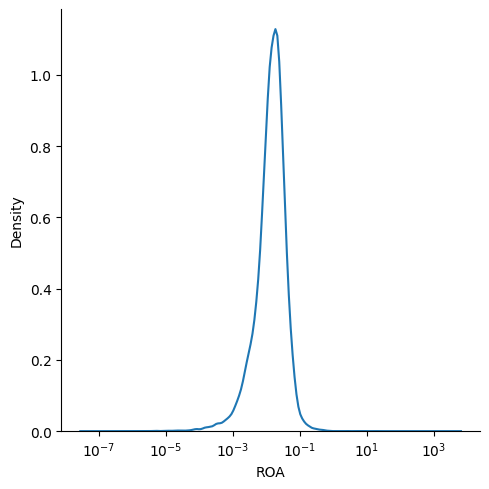

In [ ]:
sns.displot(data=fmp_df, x='ROA', kind='kde', log_scale=True)

/usr/local/lib/python3.9/dist-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


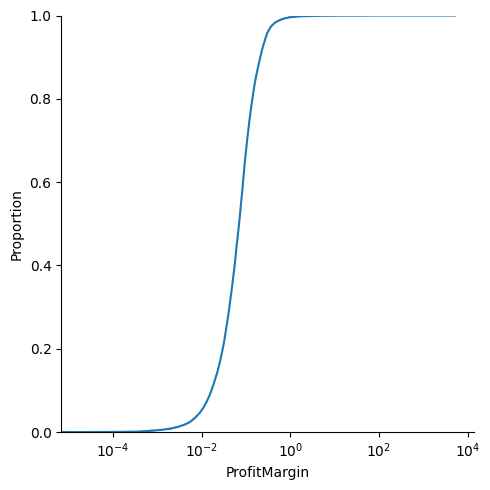

In [ ]:
# sns.displot(data=fmp_df, x='ProfitMargin', kind='ecdf', log_scale=True)

In [ ]:
o_fmp_df = fmp_df.sort_values(['symbol', 'statement_date'], ascending=True).reset_index(drop=True)
o_fmp_df

,symbol,statement_date,revenue,netIncome,totalLiabilities,totalAssets,totalStockholdersEquity,totalCurrentAssets,totalCurrentLiabilities,cashAndCashEquivalents,ROA,ROE,ProfitMargin,CurrentRatio,CashRatio,DERatio,fed_rate,industry_compact
0,A,2008-01-31,1.393000e+09,120000000.0,4.286000e+09,7.459000e+09,3.173000e+09,5.070000e+09,2.674000e+09,1.385000e+09,0.016088,0.037819,0.086145,1.896036,0.517951,1.350772,3.94,Diagnostics & Research
1,A,2008-04-30,1.456000e+09,173000000.0,4.518000e+09,7.674000e+09,3.156000e+09,5.185000e+09,3.044000e+09,1.710000e+09,0.022544,0.054816,0.118819,1.703351,0.561761,1.431559,2.28,Diagnostics & Research
2,A,2008-07-31,1.444000e+09,169000000.0,4.356000e+09,7.541000e+09,3.185000e+09,5.074000e+09,2.894000e+09,1.640000e+09,0.022411,0.053061,0.117036,1.753283,0.566690,1.367661,2.01,Diagnostics & Research
3,A,2008-10-31,1.481000e+09,231000000.0,4.878000e+09,7.437000e+09,2.559000e+09,3.208000e+09,1.325000e+09,1.405000e+09,0.031061,0.090270,0.155976,2.421132,1.060377,1.906213,0.97,Diagnostics & Research
4,A,2009-01-31,1.166000e+09,64000000.0,4.591000e+09,7.162000e+09,2.571000e+09,3.008000e+09,1.130000e+09,1.362000e+09,0.008936,0.024893,0.054889,2.661947,1.205310,1.785687,0.15,Diagnostics & Research
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28964,ZUMZ,2022-01-29,3.466770e+08,38204000.0,3.936940e+08,8.620120e+08,4.683180e+08,4.476490e+08,1.844390e+08,1.172230e+08,0.044320,0.081577,0.110201,2.427084,0.635565,0.840655,0.08,Apparel
28965,ZUMZ,2022-04-30,2.206860e+08,-397000.0,3.912170e+08,4.193210e+08,3.768970e+08,3.487930e+08,1.782970e+08,6.250100e+07,-0.000947,-0.001053,-0.001799,1.956247,0.350544,1.037994,0.33,Apparel
28966,ZUMZ,2022-07-30,2.199930e+08,3067000.0,3.823150e+08,7.606110e+08,3.782960e+08,3.555050e+08,1.812470e+08,5.914400e+07,0.004032,0.008107,0.013941,1.961439,0.326317,1.010624,1.68,Apparel
28967,ZUMZ,2022-10-29,2.375910e+08,6932000.0,3.691370e+08,7.498070e+08,3.806700e+08,3.533070e+08,1.755460e+08,4.933600e+07,0.009245,0.018210,0.029176,2.012618,0.281043,0.969703,3.08,Apparel


In [ ]:
def add_fmp_prev_period(o_fmp_df, n_fmp_df, n_periods_ago=1):
    suffix = f"_t-{n_periods_ago}"
    n_fmp_df = pd.concat([n_fmp_df, o_fmp_df.shift(n_periods_ago).add_suffix(suffix)], axis=1)
    n_fmp_df = n_fmp_df[n_fmp_df['symbol']==n_fmp_df[f'symbol{suffix}']]
    n_fmp_df = n_fmp_df.drop([f'symbol{suffix}'], axis=1)
    return n_fmp_df

In [ ]:
n_fmp_df = add_fmp_prev_period(o_fmp_df, o_fmp_df, 1)
n_fmp_df = add_fmp_prev_period(o_fmp_df, n_fmp_df, 2)
n_fmp_df = add_fmp_prev_period(o_fmp_df, n_fmp_df, 3)
n_fmp_df = add_fmp_prev_period(o_fmp_df, n_fmp_df, 4)
n_fmp_df = add_fmp_prev_period(o_fmp_df, n_fmp_df, 5)
n_fmp_df = add_fmp_prev_period(o_fmp_df, n_fmp_df, 6)
n_fmp_df = add_fmp_prev_period(o_fmp_df, n_fmp_df, 7)
n_fmp_df = add_fmp_prev_period(o_fmp_df, n_fmp_df, 8)
n_fmp_df = add_fmp_prev_period(o_fmp_df, n_fmp_df, 9)
n_fmp_df = n_fmp_df.set_index('symbol')
n_fmp_df

,statement_date,revenue,netIncome,totalLiabilities,totalAssets,totalStockholdersEquity,totalCurrentAssets,totalCurrentLiabilities,cashAndCashEquivalents,ROA,...,totalCurrentLiabilities_t-9,cashAndCashEquivalents_t-9,ROA_t-9,ROE_t-9,ProfitMargin_t-9,CurrentRatio_t-9,CashRatio_t-9,DERatio_t-9,fed_rate_t-9,industry_compact_t-9
symbol,,,,,,,,,,,,,,,,,,,,,
A,2010-04-30,1.271000e+09,108000000.0,5.135000e+09,7.767000e+09,2.624000e+09,5.712000e+09,2.709000e+09,2.646000e+09,0.013905,...,2.674000e+09,1.385000e+09,0.016088,0.037819,0.086145,1.896036,0.517951,1.350772,3.94,Diagnostics & Research
A,2010-07-31,1.384000e+09,205000000.0,6.290000e+09,9.100000e+09,2.802000e+09,5.735000e+09,2.917000e+09,2.317000e+09,0.022527,...,3.044000e+09,1.710000e+09,0.022544,0.054816,0.118819,1.703351,0.561761,1.431559,2.28,Diagnostics & Research
A,2010-10-31,1.576000e+09,292000000.0,6.460000e+09,9.696000e+09,3.228000e+09,6.169000e+09,3.083000e+09,2.649000e+09,0.030116,...,2.894000e+09,1.640000e+09,0.022411,0.053061,0.117036,1.753283,0.566690,1.367661,2.01,Diagnostics & Research
A,2011-01-31,1.519000e+09,193000000.0,4.705000e+09,8.044000e+09,3.332000e+09,4.598000e+09,1.406000e+09,2.638000e+09,0.023993,...,1.325000e+09,1.405000e+09,0.031061,0.090270,0.155976,2.421132,1.060377,1.906213,0.97,Diagnostics & Research
A,2011-04-30,1.677000e+09,200000000.0,4.688000e+09,8.649000e+09,3.953000e+09,5.096000e+09,1.592000e+09,2.975000e+09,0.023124,...,1.130000e+09,1.362000e+09,0.008936,0.024893,0.054889,2.661947,1.205310,1.785687,0.15,Diagnostics & Research
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZUMZ,2022-01-29,3.466770e+08,38204000.0,3.936940e+08,8.620120e+08,4.683180e+08,4.476490e+08,1.844390e+08,1.172230e+08,0.044320,...,1.773340e+08,3.192900e+07,0.021428,0.044933,0.072642,2.196843,0.180050,1.096880,1.55,Apparel
ZUMZ,2022-04-30,2.206860e+08,-397000.0,3.912170e+08,4.193210e+08,3.768970e+08,3.487930e+08,1.782970e+08,6.250100e+07,-0.000947,...,1.597100e+08,5.242800e+07,0.041437,0.081281,0.115235,2.583357,0.328270,0.961565,1.58,Apparel
ZUMZ,2022-07-30,2.199930e+08,3067000.0,3.823150e+08,7.606110e+08,3.782960e+08,3.555050e+08,1.812470e+08,5.914400e+07,0.004032,...,1.568810e+08,6.373100e+07,-0.024495,-0.048941,-0.153159,2.394140,0.406238,0.997971,0.05,Apparel


In [ ]:
layoffs_symbol_df

,Date,Symbol,Company,Number of Workers
0,2015-11-09,AA,Alcoa Corporation Common Stock,415
1,2012-05-01,AAL,American Airlines Group Inc. Common Stock,550
2,2012-06-28,AAL,American Airlines Group Inc. Common Stock,1
3,2012-07-01,AAL,American Airlines Group Inc. Common Stock,2
4,2012-07-23,AAL,American Airlines Group Inc. Common Stock,187
...,...,...,...,...
2105,2019-03-27,XRAY,DENTSPLY SIRONA Inc. Common Stock,49
2106,2020-04-02,XRAY,DENTSPLY SIRONA Inc. Common Stock,461
2107,2020-04-09,YELP,Yelp Inc. Common Stock,375
2108,2010-02-22,ZUMZ,Zumiez Inc. Common Stock,172


In [ ]:
n_fmp_df = n_fmp_df.reset_index()
n_fmp_df

,symbol,statement_date,revenue,netIncome,totalLiabilities,totalAssets,totalStockholdersEquity,totalCurrentAssets,totalCurrentLiabilities,cashAndCashEquivalents,...,totalCurrentLiabilities_t-9,cashAndCashEquivalents_t-9,ROA_t-9,ROE_t-9,ProfitMargin_t-9,CurrentRatio_t-9,CashRatio_t-9,DERatio_t-9,fed_rate_t-9,industry_compact_t-9
0,A,2010-04-30,1.271000e+09,108000000.0,5.135000e+09,7.767000e+09,2.624000e+09,5.712000e+09,2.709000e+09,2.646000e+09,...,2.674000e+09,1.385000e+09,0.016088,0.037819,0.086145,1.896036,0.517951,1.350772,3.94,Diagnostics & Research
1,A,2010-07-31,1.384000e+09,205000000.0,6.290000e+09,9.100000e+09,2.802000e+09,5.735000e+09,2.917000e+09,2.317000e+09,...,3.044000e+09,1.710000e+09,0.022544,0.054816,0.118819,1.703351,0.561761,1.431559,2.28,Diagnostics & Research
2,A,2010-10-31,1.576000e+09,292000000.0,6.460000e+09,9.696000e+09,3.228000e+09,6.169000e+09,3.083000e+09,2.649000e+09,...,2.894000e+09,1.640000e+09,0.022411,0.053061,0.117036,1.753283,0.566690,1.367661,2.01,Diagnostics & Research
3,A,2011-01-31,1.519000e+09,193000000.0,4.705000e+09,8.044000e+09,3.332000e+09,4.598000e+09,1.406000e+09,2.638000e+09,...,1.325000e+09,1.405000e+09,0.031061,0.090270,0.155976,2.421132,1.060377,1.906213,0.97,Diagnostics & Research
4,A,2011-04-30,1.677000e+09,200000000.0,4.688000e+09,8.649000e+09,3.953000e+09,5.096000e+09,1.592000e+09,2.975000e+09,...,1.130000e+09,1.362000e+09,0.008936,0.024893,0.054889,2.661947,1.205310,1.785687,0.15,Diagnostics & Research
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24097,ZUMZ,2022-01-29,3.466770e+08,38204000.0,3.936940e+08,8.620120e+08,4.683180e+08,4.476490e+08,1.844390e+08,1.172230e+08,...,1.773340e+08,3.192900e+07,0.021428,0.044933,0.072642,2.196843,0.180050,1.096880,1.55,Apparel
24098,ZUMZ,2022-04-30,2.206860e+08,-397000.0,3.912170e+08,4.193210e+08,3.768970e+08,3.487930e+08,1.782970e+08,6.250100e+07,...,1.597100e+08,5.242800e+07,0.041437,0.081281,0.115235,2.583357,0.328270,0.961565,1.58,Apparel
24099,ZUMZ,2022-07-30,2.199930e+08,3067000.0,3.823150e+08,7.606110e+08,3.782960e+08,3.555050e+08,1.812470e+08,5.914400e+07,...,1.568810e+08,6.373100e+07,-0.024495,-0.048941,-0.153159,2.394140,0.406238,0.997971,0.05,Apparel
24100,ZUMZ,2022-10-29,2.375910e+08,6932000.0,3.691370e+08,7.498070e+08,3.806700e+08,3.533070e+08,1.755460e+08,4.933600e+07,...,2.036000e+08,1.339050e+08,0.027102,0.054023,0.101409,2.265246,0.657687,0.993285,0.10,Apparel


In [ ]:
def find_layoff_event(row):
    company_df = layoffs_symbol_df[layoffs_symbol_df['Symbol'] == row['symbol']]
    company_df = company_df[company_df['Date'] < row['statement_date']]
    company_df = company_df[company_df['Date'] >= row['statement_date'] - pd.Timedelta(days=180)]
    # company_df = company_df[company_df['Date'] >= row['statement_date_t-1']]
    # if company_df.shape[0] > 0:
    #     print(f"{row['symbol']} {row['statement_date_t-1']} - {row['statement_date']} {company_df.shape}")
    return company_df['Number of Workers'].sum()
    

In [ ]:
# n_fmp_df['Number of Workers'] = n_fmp_df.apply(find_layoff_event)
n_fmp_df['layoff_count'] = n_fmp_df.apply(lambda r: find_layoff_event(r), axis=1)

In [ ]:
warn_fmp_df = n_fmp_df
warn_fmp_df['has_layoffs'] = warn_fmp_df['layoff_count'].map(lambda v: 1 if v > 0 else 0)
warn_fmp_df

,symbol,statement_date,revenue,netIncome,totalLiabilities,totalAssets,totalStockholdersEquity,totalCurrentAssets,totalCurrentLiabilities,cashAndCashEquivalents,...,ROA_t-9,ROE_t-9,ProfitMargin_t-9,CurrentRatio_t-9,CashRatio_t-9,DERatio_t-9,fed_rate_t-9,industry_compact_t-9,layoff_count,has_layoffs
0,A,2010-04-30,1.271000e+09,108000000.0,5.135000e+09,7.767000e+09,2.624000e+09,5.712000e+09,2.709000e+09,2.646000e+09,...,0.016088,0.037819,0.086145,1.896036,0.517951,1.350772,3.94,Diagnostics & Research,0,0
1,A,2010-07-31,1.384000e+09,205000000.0,6.290000e+09,9.100000e+09,2.802000e+09,5.735000e+09,2.917000e+09,2.317000e+09,...,0.022544,0.054816,0.118819,1.703351,0.561761,1.431559,2.28,Diagnostics & Research,0,0
2,A,2010-10-31,1.576000e+09,292000000.0,6.460000e+09,9.696000e+09,3.228000e+09,6.169000e+09,3.083000e+09,2.649000e+09,...,0.022411,0.053061,0.117036,1.753283,0.566690,1.367661,2.01,Diagnostics & Research,0,0
3,A,2011-01-31,1.519000e+09,193000000.0,4.705000e+09,8.044000e+09,3.332000e+09,4.598000e+09,1.406000e+09,2.638000e+09,...,0.031061,0.090270,0.155976,2.421132,1.060377,1.906213,0.97,Diagnostics & Research,0,0
4,A,2011-04-30,1.677000e+09,200000000.0,4.688000e+09,8.649000e+09,3.953000e+09,5.096000e+09,1.592000e+09,2.975000e+09,...,0.008936,0.024893,0.054889,2.661947,1.205310,1.785687,0.15,Diagnostics & Research,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24097,ZUMZ,2022-01-29,3.466770e+08,38204000.0,3.936940e+08,8.620120e+08,4.683180e+08,4.476490e+08,1.844390e+08,1.172230e+08,...,0.021428,0.044933,0.072642,2.196843,0.180050,1.096880,1.55,Apparel,0,0
24098,ZUMZ,2022-04-30,2.206860e+08,-397000.0,3.912170e+08,4.193210e+08,3.768970e+08,3.487930e+08,1.782970e+08,6.250100e+07,...,0.041437,0.081281,0.115235,2.583357,0.328270,0.961565,1.58,Apparel,0,0
24099,ZUMZ,2022-07-30,2.199930e+08,3067000.0,3.823150e+08,7.606110e+08,3.782960e+08,3.555050e+08,1.812470e+08,5.914400e+07,...,-0.024495,-0.048941,-0.153159,2.394140,0.406238,0.997971,0.05,Apparel,0,0
24100,ZUMZ,2022-10-29,2.375910e+08,6932000.0,3.691370e+08,7.498070e+08,3.806700e+08,3.533070e+08,1.755460e+08,4.933600e+07,...,0.027102,0.054023,0.101409,2.265246,0.657687,0.993285,0.10,Apparel,0,0


In [ ]:
display(n_fmp_df.shape)
display(warn_fmp_df.shape)

(24102, 173)

(24102, 173)

In [ ]:
def generate_change_metrics(warn_fmp_df, t_range, metrics):
    generated_feats = []
    for t in t_range:
        t_prev = t + 1
        t_s = f"t-{t}"
        t_prev_s = f"t-{t_prev}"
        for m in metrics:
            warn_fmp_df[f"{m}_change_{t_s}"] = warn_fmp_df.apply(
                lambda r: (r[f"{m}_{t_s}"] - r[f"{m}_{t_prev_s}"])/abs(r[f"{m}_{t_prev_s}"]), 
                axis=1)
            generated_feats.append(f"{m}_change_{t_s}")
    return generated_feats
            # warn_fmp_df[f"{m}_change_{t_s}"] = warn_fmp_df.apply(lambda r: 0 if r[f"netIncome_{t_s}"] > 0 else 1, axis=1)
            # warn_fmp_df[f"wc_up_{t_s}"] = warn_fmp_df.apply(lambda r: 1 if r[f"changeInWorkingCapital_{t_s}"] > 0 else 0, axis=1)
            # warn_fmp_df[f"oe_up_{t_s}"] = warn_fmp_df.apply(lambda r: 1 if r[f"operatingExpenses_{t_s}"] > r[f"operatingExpenses_{t_prev_s}"] else 0, axis=1)
            # warn_fmp_df[f"rev_up_{t_s}"] = warn_fmp_df.apply(lambda r: 1 if r[f"revenue_{t_s}"] > r[f"revenue_{t_prev_s}"] else 0, axis=1)


In [ ]:
# change_features = generate_change_metrics(
#     warn_fmp_df, 
#     range(1, 9), 
#     selected_financial_metrics)
# warn_fmp_df

In [ ]:
# avg_feats = []
# for m in ['revenue', 'netIncome', 'changeInWorkingCapital']:
#     warn_fmp_df[f'avg_{m}_change'] = warn_fmp_df.apply(
#         lambda r: (r[f"{m}_change_t-1"]+r[f"{m}_change_t-2"]+r[f"{m}_change_t-3"]+r[f"{m}_change_t-4"])/4, 
#         axis=1
#     )
#     avg_feats.append(f'avg_{m}_change')

# pos_change_ratio_feats = []
# for m in ['revenue', 'netIncome', 'changeInWorkingCapital']:
#     warn_fmp_df[f'pos_{m}_change_ratio'] = warn_fmp_df.apply(
#         lambda r: sum([1 for x in [r[f"{m}_change_t-1"],r[f"{m}_change_t-2"],r[f"{m}_change_t-3"],r[f"{m}_change_t-4"]] if x > 0])/4, 
#         axis=1
#     )
#     avg_feats.append(f'pos_{m}_change_ratio')

In [ ]:
# features = ['industry_compact', 'fed_rate']
features = []
features.extend([
    'ROA_t-1', 'ROA_t-2', 'ROA_t-3', 'ROA_t-4', 'ROA_t-5', 'ROA_t-6', 'ROA_t-7', 'ROA_t-8', 
    'ROE_t-1', 'ROE_t-2', 'ROE_t-3', 'ROE_t-4', 'ROE_t-5', 'ROE_t-6', 'ROE_t-7', 'ROE_t-8',
    'ProfitMargin_t-1', 'ProfitMargin_t-2', 'ProfitMargin_t-3', 'ProfitMargin_t-4', 'ProfitMargin_t-5', 'ProfitMargin_t-6', 'ProfitMargin_t-7', 'ProfitMargin_t-8', 
    'CurrentRatio_t-1', 'CurrentRatio_t-2', 'CurrentRatio_t-3', 'CurrentRatio_t-4', 'CurrentRatio_t-5', 'CurrentRatio_t-6', 'CurrentRatio_t-7', 'CurrentRatio_t-8', 
    'CashRatio_t-1', 'CashRatio_t-2', 'CashRatio_t-3', 'CashRatio_t-4', 'CashRatio_t-5', 'CashRatio_t-6', 'CashRatio_t-7', 'CashRatio_t-8', 
    'DERatio_t-1', 'DERatio_t-2', 'DERatio_t-3', 'DERatio_t-4', 'DERatio_t-5', 'DERatio_t-6', 'DERatio_t-7', 'DERatio_t-8', 
    'fed_rate_t-1', 'fed_rate_t-2', 'fed_rate_t-3', 'fed_rate_t-4', 'fed_rate_t-5', 'fed_rate_t-6', 'fed_rate_t-7', 'fed_rate_t-8', 
])

# features.extend(change_features)
# features.extend(avg_feats)
# features.extend(pos_change_ratio_feats)
# for metric in ['revenue', 'loss', 'netIncome', 'EPS', 'fed_rate', 'operatingExpenses']:
# for metric in ['revenue', 'loss', 'fed_rate', 'operatingExpenses']:
# for metric in ['revenue', 'loss', 'fed_rate', 'wc_up']:
# for metric in ['rev_up', 'loss', 'fed_rate', 'wc_up', 'oe_up']:
    # for t in range(1, 9):
    #     t_s = f"t-{t}"
    #     features.append(f"{metric}_{t_s}")

In [ ]:
fin_df = warn_fmp_df[features+['has_layoffs']]
X_full = fin_df[features]
y = fin_df['has_layoffs']
print(Counter(y))
X_full

Counter({0: 22029, 1: 2073})


,ROA_t-1,ROA_t-2,ROA_t-3,ROA_t-4,ROA_t-5,ROA_t-6,ROA_t-7,ROA_t-8,ROE_t-1,ROE_t-2,...,DERatio_t-7,DERatio_t-8,fed_rate_t-1,fed_rate_t-2,fed_rate_t-3,fed_rate_t-4,fed_rate_t-5,fed_rate_t-6,fed_rate_t-7,fed_rate_t-8
0,0.010430,0.003284,-0.002891,-0.015359,0.008936,0.031061,0.022411,0.022544,0.030502,0.009976,...,1.367661,1.431559,0.11,0.12,0.16,0.15,0.15,0.97,2.01,2.28
1,0.013905,0.010430,0.003284,-0.002891,-0.015359,0.008936,0.031061,0.022411,0.041159,0.030502,...,1.906213,1.367661,0.20,0.11,0.12,0.16,0.15,0.15,0.97,2.01
2,0.022527,0.013905,0.010430,0.003284,-0.002891,-0.015359,0.008936,0.031061,0.073162,0.041159,...,1.785687,1.906213,0.18,0.20,0.11,0.12,0.16,0.15,0.15,0.97
3,0.030116,0.022527,0.013905,0.010430,0.003284,-0.002891,-0.015359,0.008936,0.090458,0.073162,...,1.718479,1.785687,0.19,0.18,0.20,0.11,0.12,0.16,0.15,0.15
4,0.023993,0.030116,0.022527,0.013905,0.010430,0.003284,-0.002891,-0.015359,0.057923,0.090458,...,1.640820,1.718479,0.17,0.19,0.18,0.20,0.11,0.12,0.16,0.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24097,0.031387,0.023282,0.025923,0.042867,0.029912,0.027102,-0.024495,0.041437,0.057739,0.040381,...,0.997971,0.961565,0.08,0.10,0.06,0.09,0.09,0.10,0.05,1.58
24098,0.044320,0.031387,0.023282,0.025923,0.042867,0.029912,0.027102,-0.024495,0.081577,0.057739,...,0.993285,0.997971,0.08,0.08,0.10,0.06,0.09,0.09,0.10,0.05
24099,-0.000947,0.044320,0.031387,0.023282,0.025923,0.042867,0.029912,0.027102,-0.001053,0.081577,...,0.951485,0.993285,0.33,0.08,0.08,0.10,0.06,0.09,0.09,0.10
24100,0.004032,-0.000947,0.044320,0.031387,0.023282,0.025923,0.042867,0.029912,0.008107,-0.001053,...,0.806680,0.951485,1.68,0.33,0.08,0.08,0.10,0.06,0.09,0.09


In [ ]:
X_static_enc = pd.get_dummies(warn_fmp_df, columns=['industry_compact'])
industry_enc_columns = list(filter(lambda c: c.startswith('industry_compact_') and (not c.startswith('industry_compact_t-')), X_static_enc.columns.tolist()))
X_static_enc = X_static_enc[industry_enc_columns]
X_static_enc
X_full = pd.concat([X_full, X_static_enc], axis=1)
X_full
# X_static_enc

,ROA_t-1,ROA_t-2,ROA_t-3,ROA_t-4,ROA_t-5,ROA_t-6,ROA_t-7,ROA_t-8,ROE_t-1,ROE_t-2,...,industry_compact_Medical,industry_compact_Packaging & Containers,industry_compact_Publishing,industry_compact_Railroads,industry_compact_Real Estate,industry_compact_Restaurants,industry_compact_Retail,industry_compact_Scientific & Technical Instruments,industry_compact_Services,industry_compact_Utilities
0,0.010430,0.003284,-0.002891,-0.015359,0.008936,0.031061,0.022411,0.022544,0.030502,0.009976,...,0,0,0,0,0,0,0,0,0,0
1,0.013905,0.010430,0.003284,-0.002891,-0.015359,0.008936,0.031061,0.022411,0.041159,0.030502,...,0,0,0,0,0,0,0,0,0,0
2,0.022527,0.013905,0.010430,0.003284,-0.002891,-0.015359,0.008936,0.031061,0.073162,0.041159,...,0,0,0,0,0,0,0,0,0,0
3,0.030116,0.022527,0.013905,0.010430,0.003284,-0.002891,-0.015359,0.008936,0.090458,0.073162,...,0,0,0,0,0,0,0,0,0,0
4,0.023993,0.030116,0.022527,0.013905,0.010430,0.003284,-0.002891,-0.015359,0.057923,0.090458,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24097,0.031387,0.023282,0.025923,0.042867,0.029912,0.027102,-0.024495,0.041437,0.057739,0.040381,...,0,0,0,0,0,0,0,0,0,0
24098,0.044320,0.031387,0.023282,0.025923,0.042867,0.029912,0.027102,-0.024495,0.081577,0.057739,...,0,0,0,0,0,0,0,0,0,0
24099,-0.000947,0.044320,0.031387,0.023282,0.025923,0.042867,0.029912,0.027102,-0.001053,0.081577,...,0,0,0,0,0,0,0,0,0,0
24100,0.004032,-0.000947,0.044320,0.031387,0.023282,0.025923,0.042867,0.029912,0.008107,-0.001053,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# tl = TomekLinks(sampling_strategy='majority')
# X_tl, y_tl = tl.fit_resample(X_full, y)

# print('Original dataset shape', Counter(y))
# print('Resample dataset shape', Counter(y_tl))

In [ ]:
# smote = SMOTE()
# x_smote, y_smote = smote.fit_resample(X_tl, y_tl)

# print('Original dataset shape', Counter(y_tl))
# print('Resample dataset shape', Counter(y_smote))

In [ ]:
X = X_full
# X = X_tl
# y = y_tl
# X = x_smote
# y = y_smote
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)
print(X.shape)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

print(Counter(y_train))
print(Counter(y_val))
X_train

(24102, 91)
(15424, 91)
(3857, 91)
(4821, 91)
Counter({0: 14098, 1: 1326})
Counter({0: 3525, 1: 332})


,ROA_t-1,ROA_t-2,ROA_t-3,ROA_t-4,ROA_t-5,ROA_t-6,ROA_t-7,ROA_t-8,ROE_t-1,ROE_t-2,...,industry_compact_Medical,industry_compact_Packaging & Containers,industry_compact_Publishing,industry_compact_Railroads,industry_compact_Real Estate,industry_compact_Restaurants,industry_compact_Retail,industry_compact_Scientific & Technical Instruments,industry_compact_Services,industry_compact_Utilities
3796,0.003653,0.005901,0.007225,0.006768,0.003972,0.002244,0.007525,0.008942,0.019203,0.031571,...,0,0,0,0,0,0,0,0,0,0
12437,0.022330,0.022246,0.022394,0.020066,0.026578,0.019853,0.017255,0.006159,-0.049958,-0.047603,...,0,0,0,0,0,1,0,0,0,0
22953,0.024990,-0.009049,-0.001382,0.009818,0.029959,-0.002813,-0.008238,0.046139,0.057676,-0.021653,...,0,0,0,0,0,0,0,0,1,0
20571,0.035208,0.006338,0.019496,0.016323,0.022567,0.019572,0.019327,0.014275,0.134362,0.025428,...,0,0,0,0,0,0,1,0,0,0
9607,0.004717,0.006037,0.002708,0.004146,0.002502,0.003854,0.003166,0.003432,0.027790,0.038130,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19436,0.053461,-0.001765,0.052861,0.024689,0.051183,0.003114,0.026962,-0.041239,0.245482,-0.006798,...,0,0,0,0,0,0,0,0,0,0
3619,0.006517,-0.000296,0.007649,-0.021118,0.003556,-0.039295,-0.200808,0.005334,0.016516,-0.000762,...,1,0,0,0,0,0,0,0,0,0
3389,-0.084630,0.014912,-0.000664,-0.005995,-0.008127,0.023558,0.025959,0.049090,-0.265110,0.037322,...,1,0,0,0,0,0,0,0,0,0
4751,0.039924,0.043940,0.043099,0.040641,0.045131,0.041939,0.047445,0.042770,1.072758,1.515086,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# X_train, y_train = sampler.fit_resample(X_train, y_train)
tl = TomekLinks(sampling_strategy='majority')
X_tl, y_tl = tl.fit_resample(X_train, y_train)
print('Original dataset shape', Counter(y_train))
print('Resample dataset shape', Counter(y_tl))

# smote = SMOTE()
# X_smote, y_smote = smote.fit_resample(X_tl, y_tl)
# print('Original dataset shape', Counter(y_tl))
# print('Resample dataset shape', Counter(y_smote))

Original dataset shape Counter({0: 14098, 1: 1326})
Resample dataset shape Counter({0: 13795, 1: 1326})


In [ ]:
# X_train, y_train = X_smote, y_smote
X_train, y_train = X_tl, y_tl

In [ ]:
X_train_static = X_train[industry_enc_columns]
X_train = X_train.drop(industry_enc_columns, axis=1)

X_val_static = X_val[industry_enc_columns]
X_val = X_val.drop(industry_enc_columns, axis=1)

X_test_static = X_test[industry_enc_columns]
X_test = X_test.drop(industry_enc_columns, axis=1)
X_train

,ROA_t-1,ROA_t-2,ROA_t-3,ROA_t-4,ROA_t-5,ROA_t-6,ROA_t-7,ROA_t-8,ROE_t-1,ROE_t-2,...,DERatio_t-7,DERatio_t-8,fed_rate_t-1,fed_rate_t-2,fed_rate_t-3,fed_rate_t-4,fed_rate_t-5,fed_rate_t-6,fed_rate_t-7,fed_rate_t-8
0,0.003653,0.005901,0.007225,0.006768,0.003972,0.002244,0.007525,0.008942,0.019203,0.031571,...,3.519601,3.142617,1.55,2.04,2.38,2.41,2.27,1.95,1.82,1.51
1,0.022330,0.022246,0.022394,0.020066,0.026578,0.019853,0.017255,0.006159,-0.049958,-0.047603,...,-3.281497,-3.122474,0.08,0.08,0.10,0.07,0.09,0.09,0.09,0.05
2,0.024990,-0.009049,-0.001382,0.009818,0.029959,-0.002813,-0.008238,0.046139,0.057676,-0.021653,...,1.094977,0.782088,0.38,0.36,0.24,0.14,0.13,0.11,0.12,0.09
3,0.035208,0.006338,0.019496,0.016323,0.022567,0.019572,0.019327,0.014275,0.134362,0.025428,...,2.654953,2.932491,0.10,0.05,1.58,1.55,2.13,2.39,2.40,2.20
4,0.004717,0.006037,0.002708,0.004146,0.002502,0.003854,0.003166,0.003432,0.027790,0.038130,...,5.632967,5.866169,0.14,0.18,0.19,0.18,0.16,0.12,0.15,0.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15116,0.053461,-0.001765,0.052861,0.024689,0.051183,0.003114,0.026962,-0.041239,0.245482,-0.006798,...,1.569680,1.309069,1.15,1.15,0.90,0.54,0.40,0.39,0.37,0.34
15117,0.006517,-0.000296,0.007649,-0.021118,0.003556,-0.039295,-0.200808,0.005334,0.016516,-0.000762,...,1.305642,0.858986,0.09,0.08,0.09,0.14,0.16,0.14,0.16,0.13
15118,-0.084630,0.014912,-0.000664,-0.005995,-0.008127,0.023558,0.025959,0.049090,-0.265110,0.037322,...,2.430806,1.282494,0.09,0.09,0.08,0.65,1.55,2.04,2.38,2.41
15119,0.039924,0.043940,0.043099,0.040641,0.045131,0.041939,0.047445,0.042770,1.072758,1.515086,...,-130.345133,123.726496,0.08,0.08,0.07,0.09,0.09,0.08,0.65,1.55


In [ ]:
scaler = StandardScaler()
scaler.fit(X.drop(industry_enc_columns, axis=1))
X_train, X_val, X_test = scaler.transform(X_train), scaler.transform(X_val), scaler.transform(X_test)
print(X_train.shape)

(15121, 56)


In [ ]:
X_train = X_train.reshape((-1, int(X_train.shape[1]/7), 7), order='F')
X_test = X_test.reshape((-1, int(X_test.shape[1]/7), 7), order='F')
X_val = X_val.reshape((-1, int(X_val.shape[1]/7), 7), order='F')
print(X_train.shape)

(15121, 8, 7)


In [ ]:
def make_model(input_shape, static_input_shape, output_bias=None):
    input_layer = Input(shape=input_shape, name='INPUT_LAYER')
    static_input = Input(shape=static_input_shape, name='STATIC_INPUT_LAYER')

    lstm_layer_1 = Bidirectional(LSTM(units=10, dropout=0.2), name='LSTM_LAYER_1')(input_layer)
    # lstm_layer_1 = Bidirectional(LSTM(units=10, dropout=0.1, return_sequences=True), name='LSTM_LAYER_1')(input_layer)
    # lstm_layer_2 = Bidirectional(LSTM(units=5, dropout=0.1), name='LSTM_LAYER_2')(lstm_layer_1)

    static_layer = Dense(5, activation='relu', name='DENSE_LAYER_1')(static_input)

    combined = Concatenate(axis= 1, name='CONCATENATED_TIMESERIES_STATIC')([lstm_layer_1, static_layer])
    combined_dense_two = Dense(5, activation='relu', name='DENSE_LAYER_2')(combined)

    if output_bias is not None:
        output_bias = keras.initializers.Constant(output_bias)

    output_layer = Dense(1, activation="sigmoid", name='OUTPUT_LAYER', bias_initializer=output_bias)(combined_dense_two)

    return Model(inputs=[input_layer, static_input], outputs=output_layer)


In [ ]:
def recall_m(y_true, y_pred):
   true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
   possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
   recall = true_positives / (possible_positives + K.epsilon())
   return recall
def precision_m(y_true, y_pred):
   true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
   predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
   precision = true_positives / (predicted_positives + K.epsilon())
   return precision
def f1_m(y_true, y_pred):
   precision = precision_m(y_true, y_pred)
   recall = recall_m(y_true, y_pred)
   return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
c = Counter(y_train)
weight_for_0 = (1 / c[0]) * (y_train.shape[0] / 2.0)
weight_for_1 = (1 / c[1]) * (y_train.shape[0] / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}
initial_bias = np.log([c[1]/c[0]])
class_weight

{0: 0.5480608916274012, 1: 5.701734539969834}

In [ ]:
model = make_model(input_shape=X_train.shape[1:], static_input_shape=(X_train_static.shape[1],))
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 INPUT_LAYER (InputLayer)       [(None, 8, 7)]       0           []                               
                                                                                                  
 STATIC_INPUT_LAYER (InputLayer  [(None, 35)]        0           []                               
 )                                                                                                
                                                                                                  
 LSTM_LAYER_1 (Bidirectional)   (None, 20)           1440        ['INPUT_LAYER[0][0]']            
                                                                                                  
 DENSE_LAYER_1 (Dense)          (None, 5)            180         ['STATIC_INPUT_LAYER[0][0]'

In [ ]:
epochs = 500
batch_size = 1024
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.005),
    loss='binary_crossentropy',
    metrics=[recall_m, precision_m, f1_m],
)

keras_callbacks = [
    callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
        # "best_model.h5", save_best_only=True, monitor="val_f1_m", mode="max"
    ),
    callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
        # monitor="val_f1_m", factor=0s8, patience=30, min_lr=0.001
    ),
    # callbacks.EarlyStopping(
    #     monitor="val_loss", patience=100, verbose=1
    #     # monitor="val_f1_m", patience=100, verbose=1
    # ),
]

history = model.fit(
    [X_train, X_train_static],
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=keras_callbacks,
    shuffle=True,
    class_weight=class_weight,
    validation_data = ([X_val, X_val_static], y_val)
)

Epoch 1/500
15/15 [==============================] - 6s 104ms/step - loss: 0.6843 - recall_m: 0.3160 - precision_m: 0.1146 - f1_m: 0.1624 - val_loss: 0.7089 - val_recall_m: 0.4840 - val_precision_m: 0.1369 - val_f1_m: 0.2134 - lr: 0.0050
Epoch 2/500
15/15 [==============================] - 0s 28ms/step - loss: 0.6700 - recall_m: 0.4617 - precision_m: 0.1386 - f1_m: 0.2127 - val_loss: 0.6610 - val_recall_m: 0.4727 - val_precision_m: 0.1465 - val_f1_m: 0.2235 - lr: 0.0050
Epoch 3/500
15/15 [==============================] - 0s 26ms/step - loss: 0.6659 - recall_m: 0.4490 - precision_m: 0.1445 - f1_m: 0.2183 - val_loss: 0.6728 - val_recall_m: 0.4759 - val_precision_m: 0.1432 - val_f1_m: 0.2200 - lr: 0.0050
Epoch 4/500
15/15 [==============================] - 0s 24ms/step - loss: 0.6618 - recall_m: 0.4660 - precision_m: 0.1435 - f1_m: 0.2189 - val_loss: 0.6715 - val_recall_m: 0.4788 - val_precision_m: 0.1440 - val_f1_m: 0.2213 - lr: 0.0050
Epoch 5/500
15/15 [==============================] 

In [ ]:
res = model.evaluate([X_test, X_test_static], y_test)
res

151/151 [==============================] - 0s 3ms/step - loss: 0.6039 - recall_m: 0.5874 - precision_m: 0.1519 - f1_m: 0.2307


[0.6039314866065979,
 0.5874487161636353,
 0.1519002765417099,
 0.23070639371871948]

151/151 [==============================] - 2s 4ms/step


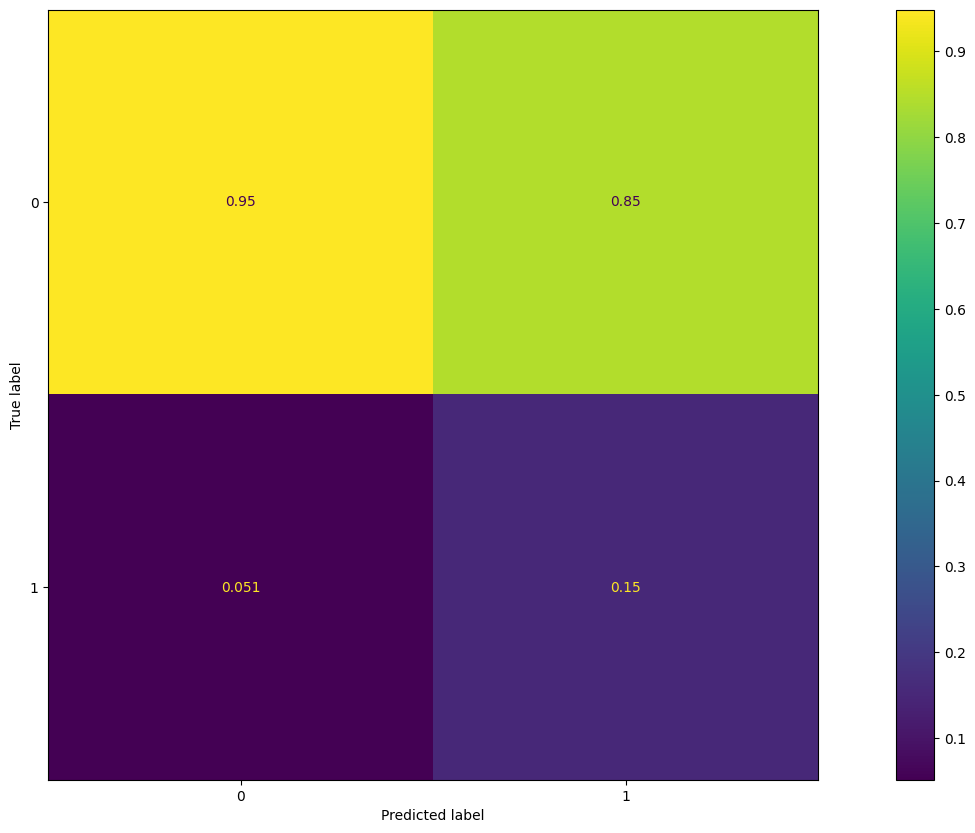

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_test_hat = model.predict([X_test, X_test_static])
y_test_hat = list([1 if x[0] > 0.5 else 0 for x in y_test_hat.tolist()])

#Create confusion matrix and normalizes it over predicted (columns)
cm = confusion_matrix(y_test, y_test_hat , normalize='pred')
# print(result)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()

In [ ]:
import matplotlib.pyplot as plt
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams["figure.figsize"] = (20,10)

def plot_loss(history, label, n):
#   Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')



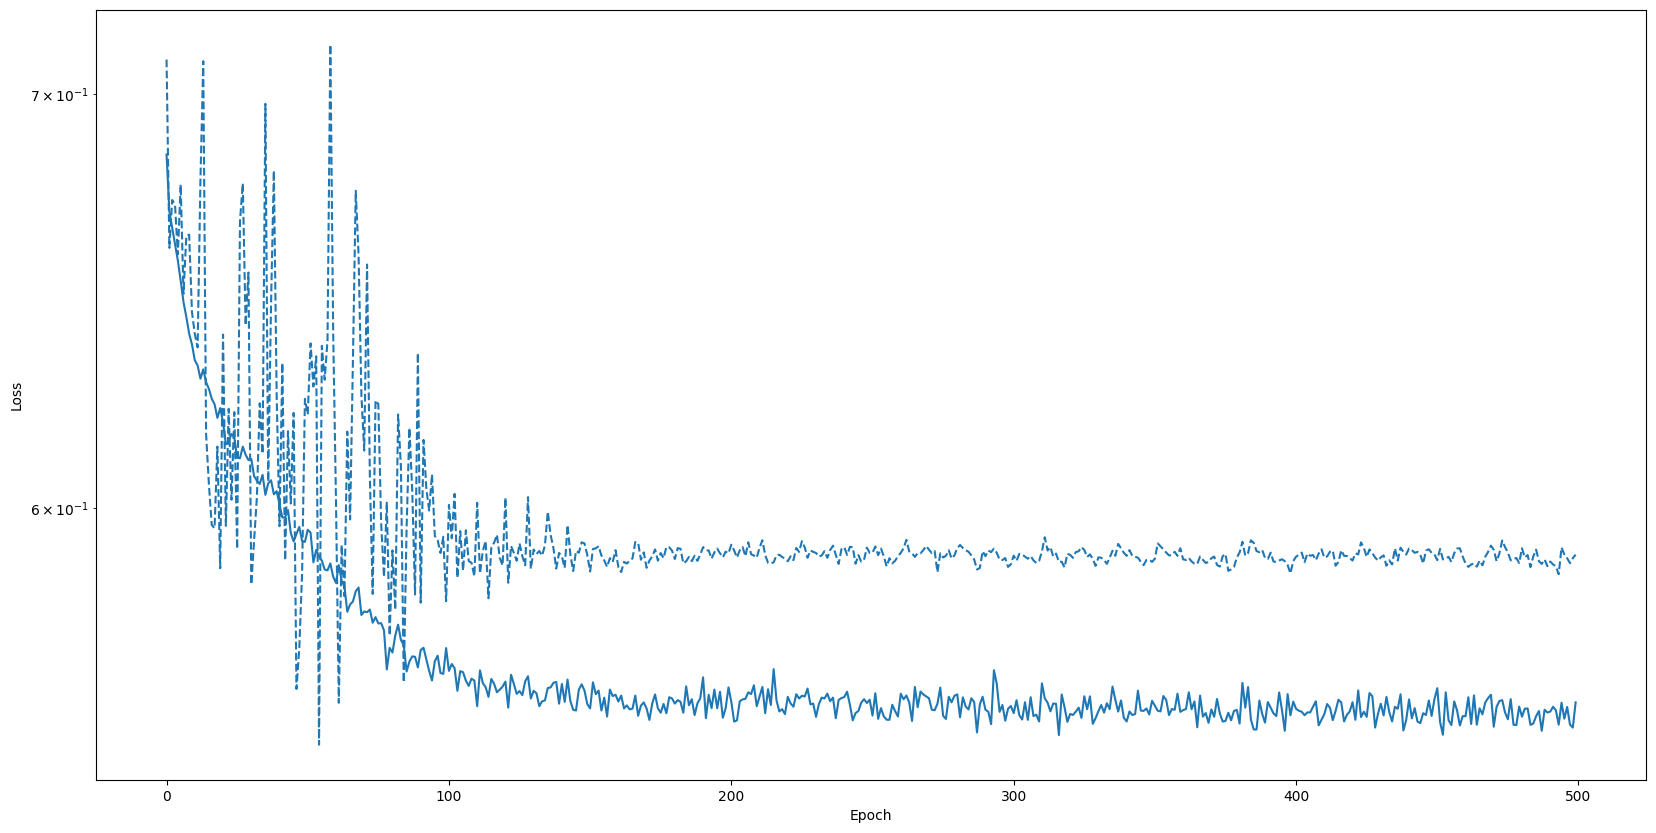

In [ ]:
plot_loss(history, "loss", 0)

In [ ]:
def do_grid_search(X, y, model, param_grid, scoring, refit):
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=0.2, stratify=y)
    print(Counter(y_train))
    print(Counter(y_test))

    gs = GridSearchCV(
        model,
        param_grid=param_grid,
        scoring=scoring,
        refit='auc',
        n_jobs=-1,
        return_train_score=True,
        cv=5
    )
    gs.fit(X_train, y_train)

    y_test_hat = gs.predict(X_test)
    y_train_hat = gs.predict(X_train)

    print(f"train f1 = {f1_score(y_train, y_train_hat)}")
    print(f"test f1 = {f1_score(y_test, y_test_hat)}")

    print(f"train recall = {recall_score(y_train, y_train_hat)}")
    print(f"test recall = {recall_score(y_test, y_test_hat)}")

    print(f"train precision = {precision_score(y_train, y_train_hat)}")
    print(f"test precision = {precision_score(y_test, y_test_hat)}")

    print(f"train roc_auc = {roc_auc_score(y_train, y_train_hat)}")
    print(f"test roc_auc = {roc_auc_score(y_test, y_test_hat)}")

    print(f"train accuracy = {accuracy_score(y_train, y_train_hat)}")
    print(f"test accuracy = {accuracy_score(y_test, y_test_hat)}")

In [ ]:
scoring = {"f1": "f1", "auc": "roc_auc", "accuracy": "accuracy", "recall": "recall", "precision": "precision"}
refit = "auc"
lr_model = LogisticRegression(
    random_state=42,
    class_weight='balanced', 
    max_iter=1000)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', lr_model)
])
param_grid = {}
do_grid_search(X, y, pipeline, param_grid, scoring, refit)

Counter({0: 17623, 1: 1658})
Counter({0: 4406, 1: 415})
train f1 = 0.24155875589979425
test f1 = 0.22222222222222227
train recall = 0.6019300361881785
test recall = 0.5445783132530121
train precision = 0.15109765329295988
test precision = 0.13959234095120446
train roc_auc = 0.641883136462131
test roc_auc = 0.6142092655688574
train accuracy = 0.6749649914423526
test accuracy = 0.6718523127981747


In [ ]:
dt_model = DecisionTreeClassifier(
    random_state=42, 
    class_weight='balanced'
)
param_grid = {
    "min_samples_split": range(2, 101, 20),
    "max_depth": [5, 7, 10],
}
do_grid_search(X, y, dt_model, param_grid, scoring, refit)

Counter({0: 17623, 1: 1658})
Counter({0: 4406, 1: 415})
train f1 = 0.272657026161828
test f1 = 0.22232063773250665
train recall = 0.7448733413751508
test recall = 0.6048192771084338
train precision = 0.1668693419808134
test precision = 0.13619099294628323
train roc_auc = 0.6974948333159589
test roc_auc = 0.6217469059169041
train accuracy = 0.6582646128312847
test accuracy = 0.6357602157228791


In [ ]:
rf_model = RandomForestClassifier(
    random_state=42, 
    class_weight='balanced'
)
param_grid = {
    "n_estimators": range(10, 51, 10),
    "max_depth": range(2, 5, 1),
}
do_grid_search(X, y, rf_model, param_grid, scoring, refit)

Counter({0: 17623, 1: 1658})
Counter({0: 4406, 1: 415})
train f1 = 0.26492640933074146
test f1 = 0.24084350721420641
train recall = 0.5753920386007237
test recall = 0.5228915662650603
train precision = 0.17207792207792208
test precision = 0.15645277577505406
train roc_auc = 0.6574684757493207
test roc_auc = 0.6286722924380226
train accuracy = 0.7254291789844926
test accuracy = 0.716241443683883


In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000)
tsne_results = tsne.fit_transform(X_full.values)


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 24102 samples in 0.030s...
[t-SNE] Computed neighbors for 24102 samples in 8.602s...
[t-SNE] Computed conditional probabilities for sample 1000 / 24102
[t-SNE] Computed conditional probabilities for sample 2000 / 24102
[t-SNE] Computed conditional probabilities for sample 3000 / 24102
[t-SNE] Computed conditional probabilities for sample 4000 / 24102
[t-SNE] Computed conditional probabilities for sample 5000 / 24102
[t-SNE] Computed conditional probabilities for sample 6000 / 24102
[t-SNE] Computed conditional probabilities for sample 7000 / 24102
[t-SNE] Computed conditional probabilities for sample 8000 / 24102
[t-SNE] Computed conditional probabilities for sample 9000 / 24102
[t-SNE] Computed conditional probabilities for sample 10000 / 24102
[t-SNE] Computed conditional probabilities for sample 11000 / 24102
[t-SNE] Computed conditional probabilities for sample 12000 / 24102
[t-SNE] Computed conditional probabilities for sa

<Axes: >

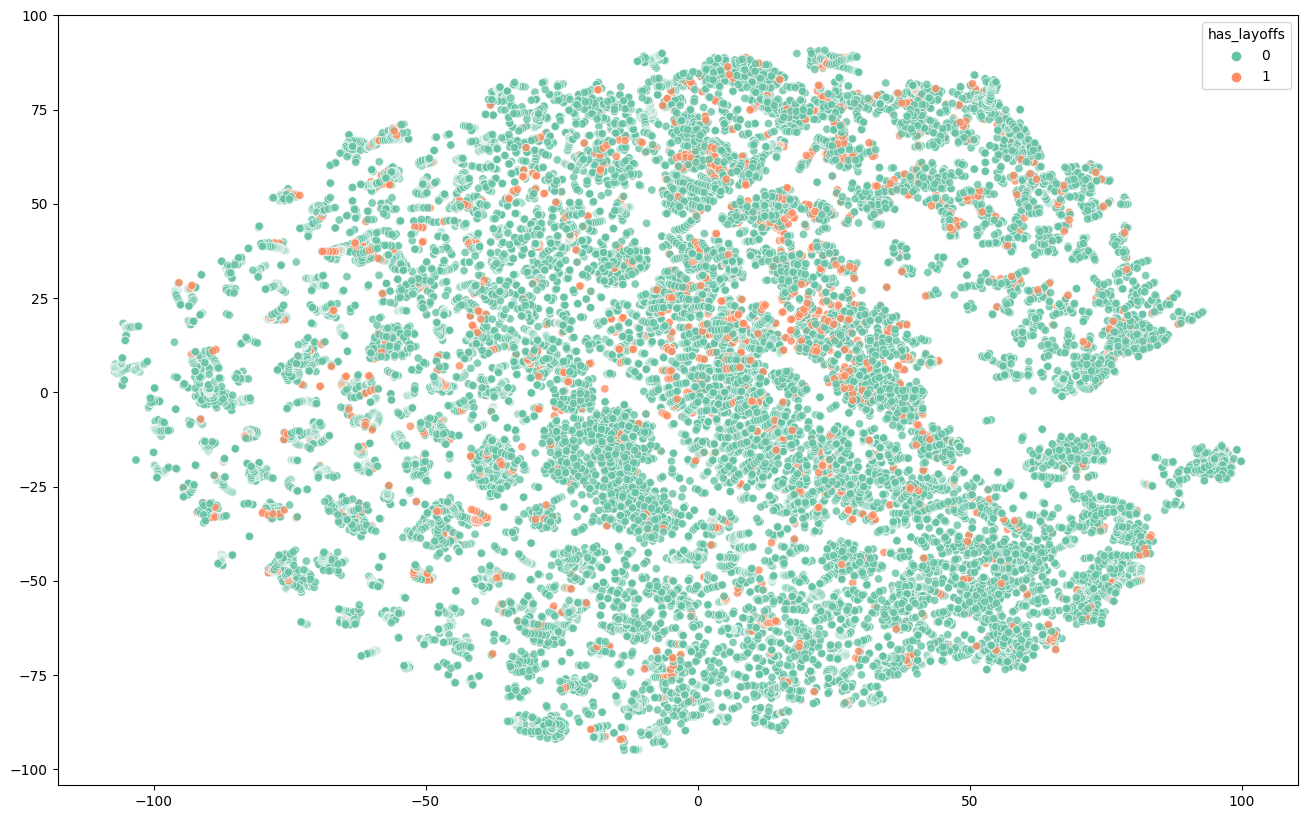

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=y,
    palette=sns.color_palette("Set2", 2),
    legend="full",
    alpha=0.8
)

In [ ]:
pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(X_full.values)

tsne_pca = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=1000)
tsne_pca_results = tsne_pca.fit_transform(pca_result_50)

<Axes: >

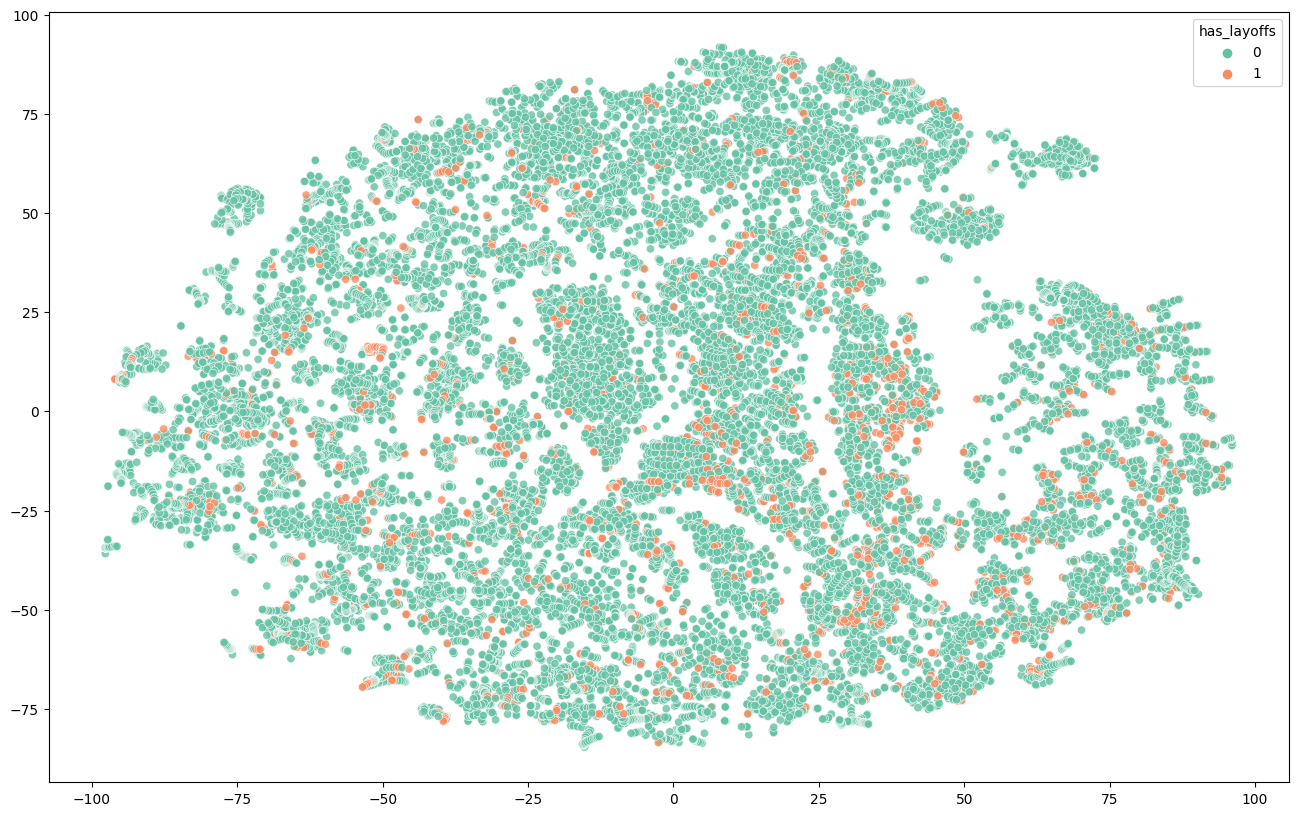

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne_pca_results[:,0], y=tsne_pca_results[:,1],
    hue=y,
    palette=sns.color_palette("Set2", 2),
    legend="full",
    alpha=0.8
)